In [1]:
# This notebook will contain only some NLP methods such as n-grams because the full notebook was getting too cumbersum

In [2]:
# imports
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [3]:
df_lab = pd.read_csv('Lab-Data.csv', index_col=0) # index_col stops index being read as column
df_turk = pd.read_csv('Turk-Data.csv', index_col=0)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df_lab

,button,event_type,target,time,x,y,step,turkId,file
0,1,mousedown,"[id=""alloc-slider-return-4""]>svg>g>circle",0.000000,397.0,647.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
1,1,mouseup,"[id=""alloc-slider-return-4""]>svg>g>circle",0.547000,423.0,642.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
2,1,click,"[id=""alloc-slider-return-4""]>svg>g>circle",0.547000,423.0,642.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
3,1,mousedown,"[id=""alloc-slider-return-4""]>svg>g>circle",1.176995,426.0,642.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
4,1,mousedirchange,"[id=""alloc-slider-return-4""]>svg>g>circle",1.790000,440.0,640.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
...,...,...,...,...,...,...,...,...,...
58280,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,1,ID18,study_results.all.json
58281,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,2,ID18,study_results.all.json
58282,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,3,ID18,study_results.all.json
58283,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,4,ID18,study_results.all.json


In [5]:
# RENAME LABS

df_lab.loc[df_lab['target'].str.contains('slider-return-0'), 'target'] = 'slider-return-0'
df_lab.loc[df_lab['target'].str.contains('slider-return-1'), 'target'] = 'slider-return-1'
df_lab.loc[df_lab['target'].str.contains('slider-return-2'), 'target'] = 'slider-return-2'
df_lab.loc[df_lab['target'].str.contains('slider-return-3'), 'target'] = 'slider-return-3'
df_lab.loc[df_lab['target'].str.contains('slider-return-4'), 'target'] = 'slider-return-4'
df_lab.loc[df_lab['target'].str.contains('slider-return-5'), 'target'] = 'slider-return-5'

# risk sliders
df_lab.loc[df_lab['target'].str.contains('slider-risk-0'), 'target'] = 'slider-risk-0'
df_lab.loc[df_lab['target'].str.contains('slider-risk-1'), 'target'] = 'slider-risk-1'
df_lab.loc[df_lab['target'].str.contains('slider-risk-2'), 'target'] = 'slider-risk-2'
df_lab.loc[df_lab['target'].str.contains('slider-risk-3'), 'target'] = 'slider-risk-3'
df_lab.loc[df_lab['target'].str.contains('slider-risk-4'), 'target'] = 'slider-risk-4'
df_lab.loc[df_lab['target'].str.contains('slider-risk-5'), 'target'] = 'slider-risk-5'

#buttons


# interesting to note that a typical Lab target may be [id="alloc-slider-risk-4"]>svg
# Where as a Turk might be html > body > main > div#content > form#portfolio-selection
# > div.investment-test > div.portfolio-interface.row > div.stock-selection.large-7.columns 
# > div.stock-allocator.row.valign-middle > div.large-4.columns > div#alloc-slider-return-0.sparkline.narrow.return 
# > svg.chart.control > g > circle.handle
# We can use the same method to rename them even though the naming scheme is different

In [6]:
# RENAME TURKS

# return sliders
df_turk.loc[df_turk['target'].str.contains('slider-return-0'), 'target'] = 'slider-return-0'
df_turk.loc[df_turk['target'].str.contains('slider-return-1'), 'target'] = 'slider-return-1'
df_turk.loc[df_turk['target'].str.contains('slider-return-2'), 'target'] = 'slider-return-2'
df_turk.loc[df_turk['target'].str.contains('slider-return-3'), 'target'] = 'slider-return-3'
df_turk.loc[df_turk['target'].str.contains('slider-return-4'), 'target'] = 'slider-return-4'
df_turk.loc[df_turk['target'].str.contains('slider-return-5'), 'target'] = 'slider-return-5'

# risk sliders
df_turk.loc[df_turk['target'].str.contains('slider-risk-0'), 'target'] = 'slider-risk-0'
df_turk.loc[df_turk['target'].str.contains('slider-risk-1'), 'target'] = 'slider-risk-1'
df_turk.loc[df_turk['target'].str.contains('slider-risk-2'), 'target'] = 'slider-risk-2'
df_turk.loc[df_turk['target'].str.contains('slider-risk-3'), 'target'] = 'slider-risk-3'
df_turk.loc[df_turk['target'].str.contains('slider-risk-4'), 'target'] = 'slider-risk-4'
df_turk.loc[df_turk['target'].str.contains('slider-risk-5'), 'target'] = 'slider-risk-5'

#buttons
df_turk.loc[df_turk['target'].str.contains('buy-button'), 'target'] = 'buy-button'
df_turk.loc[df_turk['target'].str.contains('button.save-portfolio'), 'target'] = 'save-portfolio-button'

# Idea: maybe only use mouseevents of click/mousedown to reduce the number of events?

df_turk.to_csv('Turk-Data-renamed.csv')

df_turk

,button,event_type,target,time,x,y,step,turkId
0,1,mousedown,alloc-slider-1,0.000,477.0,405.0,1,A35YFAFWP33C70
1,1,mouseup,alloc-slider-1,0.111,478.0,405.0,1,A35YFAFWP33C70
2,1,click,alloc-slider-1,0.111,478.0,405.0,1,A35YFAFWP33C70
3,1,mousedown,alloc-slider-1,1.516,479.0,405.0,1,A35YFAFWP33C70
4,1,mousedirchange,alloc-slider-1,2.395,543.0,403.0,1,A35YFAFWP33C70
...,...,...,...,...,...,...,...,...
1293068,1,click,buy-button,258.656,500.0,2198.0,1,A15781PHGW377Y
1293069,1,click,buy-button,258.656,500.0,2198.0,2,A15781PHGW377Y
1293070,1,click,buy-button,258.656,500.0,2198.0,3,A15781PHGW377Y
1293071,1,click,buy-button,258.656,500.0,2198.0,4,A15781PHGW377Y


In [7]:



def calculate_ngrams(dataframe, n):
    # TODO docstring
    # will return a dataframe of ngrams and frequency given n
    # Can take a while to compute
    
    IDs = dataframe['turkId'].unique()
    all_ngrams = []

    for ID in IDs:
        # Get targets of each user
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)               # creates ngram generator, can be used to find ngrams
        ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency
        common_ngrams = ngrams_distribution.most_common()       # converts to list

        # append this useres ngrams to all ngrams
        # extend rather than append to iterate over list and not add a list of items as a single item.
        all_ngrams.extend(common_ngrams)

    # Convert list to dataframe
    df_ngrams = pd.DataFrame(all_ngrams, columns =['n-grams', 'Frequency'])
    df_ngrams = df_ngrams.astype(dtype= {"n-grams":"object", "Frequency":"int64"})

    # Change n-grams series from list of tuples to list of strings  # https://stackoverflow.com/questions/59993097/how-can-i-join-tuples-to-strings-in-a-pandas-dataframe
    df_ngrams['n-grams'] = df_ngrams['n-grams'].agg(''.join)

    # Sum the frequencies of similar ngrams.
    df_ngrams = df_ngrams.groupby(['n-grams']).sum().reset_index().sort_values(by='Frequency', ascending=False)

    # 'Normalise' the frequencies to compare lab and turk.
    # frequency of ngram divided by number of users
    df_ngrams['Relative Frequency'] = df_ngrams['Frequency'].divide(len(IDs))
    return df_ngrams.reset_index(drop=True)

# NOTE: This wont take into account outliers. 
# Say if noone touched slider 2 other than 1 user, we would still say slider 2 was very frequent event if it was only 1 user.

def visualise_ngrams(ngrams_dataframe, head_size):
# Plots bar graph showing frequency of ngrams
# Head_size determines how many unique n-grams we show
    plt.bar(ngrams_dataframe['n-grams'].head(head_size), ngrams_dataframe['Relative Frequency'].head(head_size))
    plt.xlabel("n-grams")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Lab unigrams")


In [8]:
lab_unigrams = calculate_ngrams(df_lab, 1)
print(lab_unigrams.head())
turk_unigrams = calculate_ngrams(df_turk, 1)
print(turk_unigrams.head())


n-grams  Frequency  Relative Frequency
0  slider-return-3       7126          395.888889
1  slider-return-4       4680          260.000000
2  slider-return-1       4247          235.944444
3  slider-return-2       4234          235.222222
4  slider-return-0       3229          179.388889
                                             n-grams  Frequency  \
0                                     alloc-slider-2     170652   
1                                     alloc-slider-5     155753   
2                                     alloc-slider-4     153602   
3  html > body > main > div#content > form#portfo...     139763   
4                                     alloc-slider-1     131002   

   Relative Frequency  
0          370.177874  
1          337.859002  
2          333.193059  
3          303.173536  
4          284.169197  


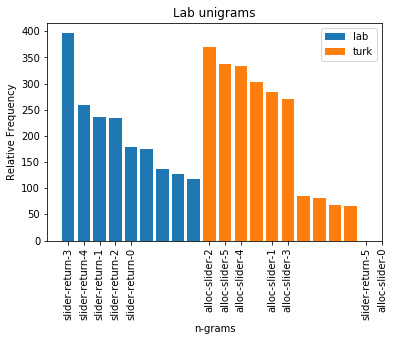

In [9]:
plt.bar(lab_unigrams['n-grams'].head(10), lab_unigrams['Relative Frequency'].head(10), label='lab')
plt.bar(turk_unigrams['n-grams'].head(10), turk_unigrams['Relative Frequency'].head(10), label='turk')

plt.xticks(('slider-return-0', 'slider-return-1', 'slider-return-2', 'slider-return-3', 'slider-return-4', 'slider-return-5',
    'alloc-slider-0', 'alloc-slider-1', 'alloc-slider-2', 'alloc-slider-3', 'alloc-slider-4', 'alloc-slider-5'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab unigrams")
plt.legend(loc='best')

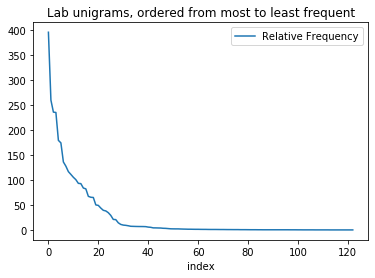

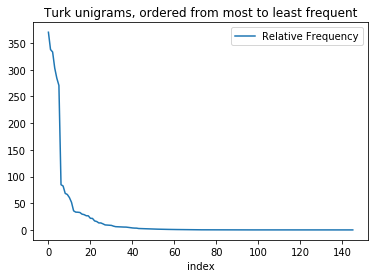

In [10]:
# These plots show the frequency of different unique n-grams in Lab and Turk data.
# I can see that anything after the 20th most frequent item contains almost no occurances so it can be removed.

lab_unigrams.reset_index().plot.line(x='index', y='Relative Frequency', title='Lab unigrams, ordered from most to least frequent')
turk_unigrams.reset_index().plot.line(x='index', y='Relative Frequency', title='Turk unigrams, ordered from most to least frequent')

,n-grams,Frequency,Relative Frequency
0,slider-return-3,7126,395.888889
1,slider-return-4,4680,260.000000
2,slider-return-1,4247,235.944444
3,slider-return-2,4234,235.222222
4,slider-return-0,3229,179.388889
...,...,...,...
118,"[id=""portfolio-stats""]>svg>g>g:nth-child(2)>g:...",1,0.055556
119,"[id=""content""]>hr",1,0.055556
120,"[id=""portfolio-selection""]>div:nth-child(1)>di...",1,0.055556
121,"[id=""survey-container""]>div",1,0.055556


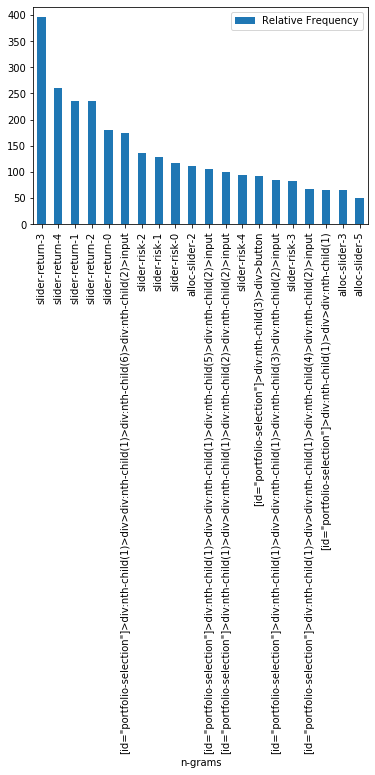

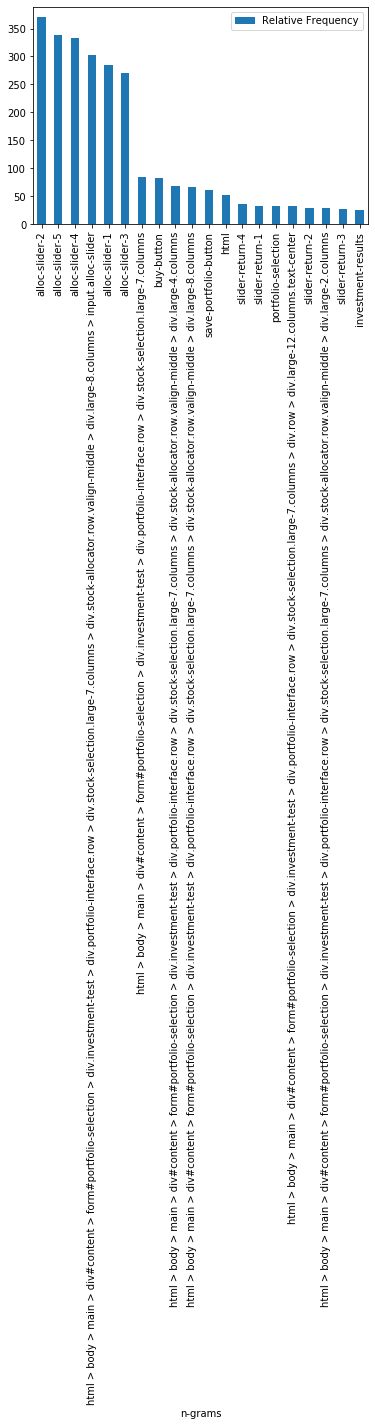

In [11]:
lab_unigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency')
turk_unigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency')

# Create these plots but with a breakdown in each column showing what ID it came from.
# This will help us identidy any outliers, and remove them if they are skewing the resutls.
# TODO create a stacked bar chart in tableau by adding column to n-grams dataframe of ID.

lab_unigrams

Now we've done some exploration into unigrams, lets look at tri-grams to see if theres anything interesting going on.


In [12]:
lab_trigrams = calculate_ngrams(df_lab, 3)
turk_trigrams = calculate_ngrams(df_turk, 3)

print(lab_trigrams.head())
print(turk_trigrams.head())

n-grams  Frequency  \
0      slider-return-3slider-return-3slider-return-3       6786   
1      slider-return-4slider-return-4slider-return-4       4390   
2      slider-return-1slider-return-1slider-return-1       3946   
3      slider-return-2slider-return-2slider-return-2       3912   
4  [id="portfolio-selection"]>div:nth-child(1)>di...       3056   

   Relative Frequency  
0          377.000000  
1          243.888889  
2          219.222222  
3          217.333333  
4          169.777778  
                                             n-grams  Frequency  \
0         alloc-slider-2alloc-slider-2alloc-slider-2     159964   
1         alloc-slider-5alloc-slider-5alloc-slider-5     147588   
2         alloc-slider-4alloc-slider-4alloc-slider-4     143699   
3  html > body > main > div#content > form#portfo...     137327   
4         alloc-slider-1alloc-slider-1alloc-slider-1     123584   

   Relative Frequency  
0          346.993492  
1          320.147505  
2          311.711497  

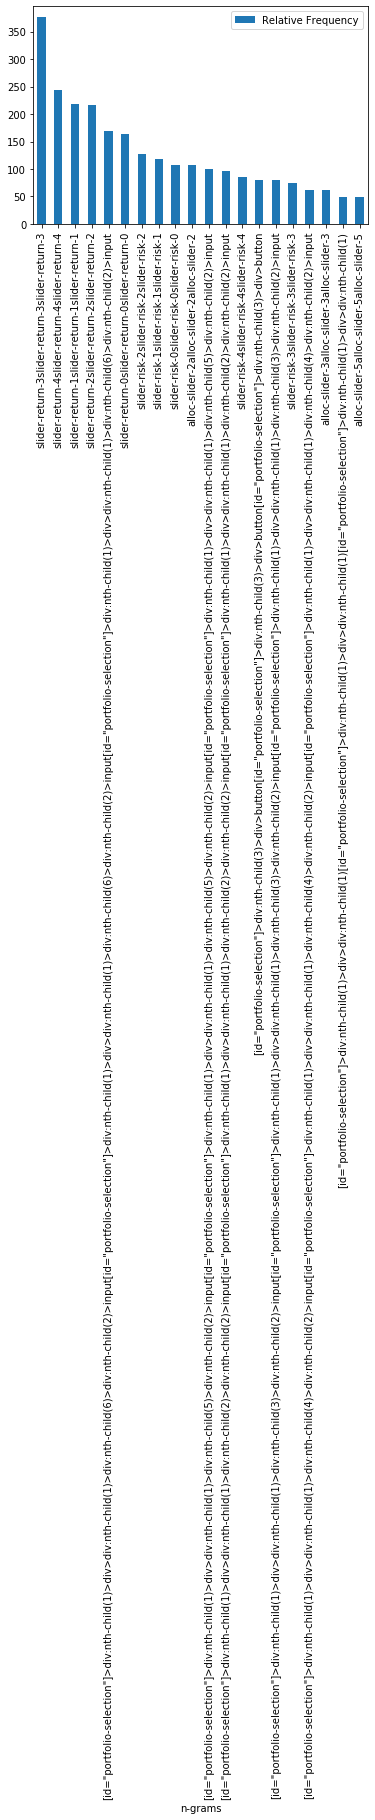

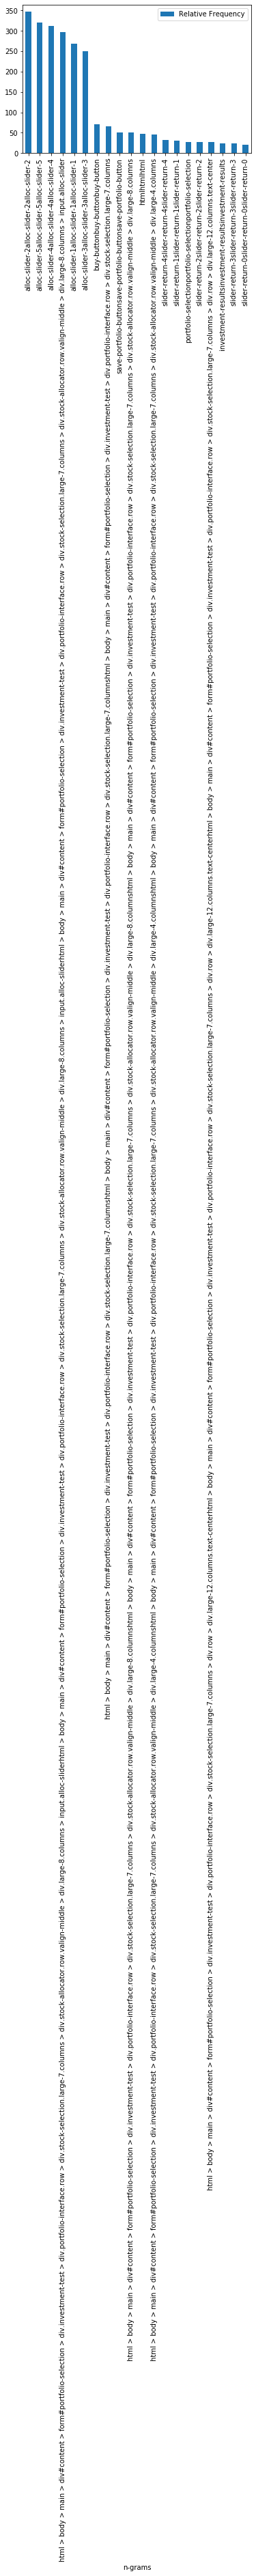

In [13]:
lab_trigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency')
turk_trigrams.head(20).plot.bar(x='n-grams', y='Relative Frequency')

In [14]:
turk_trigrams

,n-grams,Frequency,Relative Frequency
0,alloc-slider-2alloc-slider-2alloc-slider-2,159964,346.993492
1,alloc-slider-5alloc-slider-5alloc-slider-5,147588,320.147505
2,alloc-slider-4alloc-slider-4alloc-slider-4,143699,311.711497
3,html > body > main > div#content > form#portfo...,137327,297.889371
4,alloc-slider-1alloc-slider-1alloc-slider-1,123584,268.078091
...,...,...,...
7107,html > body > main > div#content > form#portfo...,1,0.002169
7108,html > body > main > div#content > form#portfo...,1,0.002169
7109,html > body > main > div#content > form#portfo...,1,0.002169
7110,html > body > main > div#content > form#portfo...,1,0.002169


In [15]:
def tableau_table(dataframe, n):
    # TODO docstring
    # Same as calculate ngrams but remove sum calculation.

    IDs = dataframe['turkId'].unique()
    all_ngrams = np.empty([0,3])

    for ID in IDs:
        # Get targets of each user
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)              # creates ngram generator, can be used to find ngrams
        ngrams_distribution = nltk.FreqDist(ngrams_generator)   # nltk distribution. in form ngrams:frequency
        common_ngrams = ngrams_distribution.most_common()       # converts to list
        common_ngrams = np.array(common_ngrams)                 # List into np to make operations easier


        # Create list of all users IDs as a new column
        # Will use to see if any users are contributing too many ngrams to the data.
        num_user_targets = common_ngrams.shape[0]
        repeated_ID = np.empty([num_user_targets, 1], dtype=object)
        repeated_ID.fill(ID)

        common_ngrams_ID = np.hstack((common_ngrams, repeated_ID))

        # append this useres ngrams to all ngrams
        # extend rather than append to iterate over list and not add a list of items as a single item.
        #all_ngrams.extend(common_ngrams)

        all_ngrams = np.concatenate((all_ngrams,common_ngrams_ID))

    # Convert list to dataframe
    df_ngrams = pd.DataFrame(all_ngrams, columns =['n-grams', 'Frequency', 'ID'])
    df_ngrams = df_ngrams.astype(dtype= {"n-grams":"object", "Frequency":"int64"})

    # Change n-grams series from list of tuples to list of strings  # https://stackoverflow.com/questions/59993097/how-can-i-join-tuples-to-strings-in-a-pandas-dataframe
    df_ngrams['n-grams'] = df_ngrams['n-grams'].agg(''.join)

    # Sum the frequencies of similar ngrams.
    #df_ngrams = df_ngrams.groupby(['n-grams']).sum().reset_index().sort_values(by='Frequency', ascending=False)

    # 'Normalise' the frequencies to compare lab and turk.
    # frequency of ngram divided by number of users
    df_ngrams['Relative Frequency'] = df_ngrams['Frequency'].divide(len(IDs))

    return df_ngrams.reset_index(drop=True)

tableau_lab = tableau_table(df_lab, 1)
tableau_lab.to_csv('tableau_lab.csv')
tableau_turk = tableau_table(df_turk, 1)
tableau_turk.to_csv('tableau_turk.csv')

In [16]:
#

In [17]:
#

In [18]:
#

In [19]:
#TODO: https://medium.com/@a.ydobon/justforfunpython-n-gram-to-quantify-similarity-between-sentences-2d61e68a478c